In [ ]:
!pip install pretty_midi mido

In [ ]:
import numpy as np
import pandas as pd
import pretty_midi
import matplotlib.pyplot as plt
import os
import seaborn as sns
import mido

from scipy.stats import entropy

## **Objective measures**
#### **Pitch diversities**
One of the most basic objective metrics is the pitch diversity of the song. It measures the ratio between the unique pitches and all of the pitches the model generates. Here we define a function to extract the pitches:

In [ ]:
def extract_pitches_from_midi(filepath):
    midi = pretty_midi.PrettyMIDI(filepath)
    pitches = []

    for instrument in midi.instruments:
        for note in instrument.notes:
            pitches.append(note.pitch)

    return pitches

The pitch diversity is calculated by dividing the number of unique pitches by the count of all pitches.

In [ ]:
def calculate_pitch_diversity(pitches):
    unique_pitches = len(np.unique(pitches))
    pitch_diversity = unique_pitches / len(pitches)
    return pitch_diversity

Let's calculate the pitch diversities for the samples our model generated. Starting with the Many-to-One GRU:

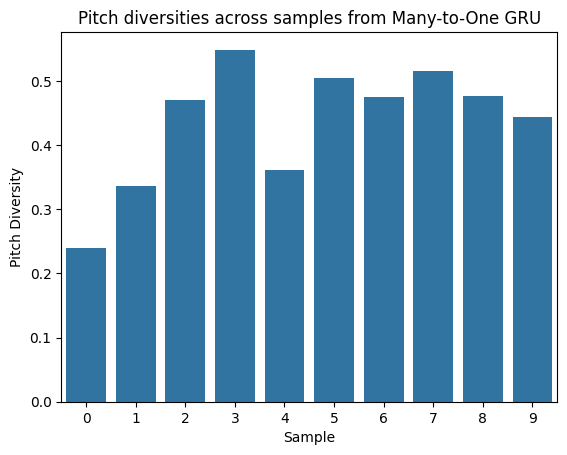

In [ ]:
many_to_one_gru_generated_path = "../saved_data/samples/many_to_one_gru/"
pitch_diversities_gru = []
for i in range(10):
    pitches = extract_pitches_from_midi(os.path.join(many_to_one_gru_generated_path, f"many_to_one_gru_generated_song_{i+1}.mid"))
    pitch_diversities_gru.append(calculate_pitch_diversity(pitches))

sns.barplot(pitch_diversities_gru)
plt.title("Pitch diversities across samples from Many-to-One GRU")
plt.xlabel("Sample")
plt.ylabel("Pitch Diversity")
plt.show()

The diversities seem moderate, but we can make conclusions after we calculate the diversities for the real data.

Now let's take a look at the diversities for the Many-to-One LSTM:

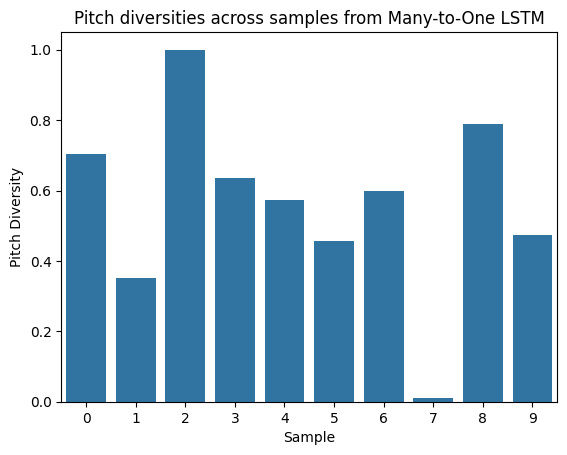

In [ ]:
many_to_one_lstm_generated_path = "../saved_data/samples/many_to_one_lstm/"
pitch_diversities_lstm = []
for i in range(10):
    pitches = extract_pitches_from_midi(os.path.join(many_to_one_lstm_generated_path, f"many_to_one_lstm_generated_song_{i+1}.mid"))
    pitch_diversities_lstm.append(calculate_pitch_diversity(pitches))

sns.barplot(pitch_diversities_lstm)
plt.title("Pitch diversities across samples from Many-to-One LSTM")
plt.xlabel("Sample")
plt.ylabel("Pitch Diversity")
plt.show()

Here, the differences between the samples are bigger, but overall, the pitches are mode diverse, compared to the Many-to-One GRU model.

Now it's time for the Encoder-Decoder architecture:

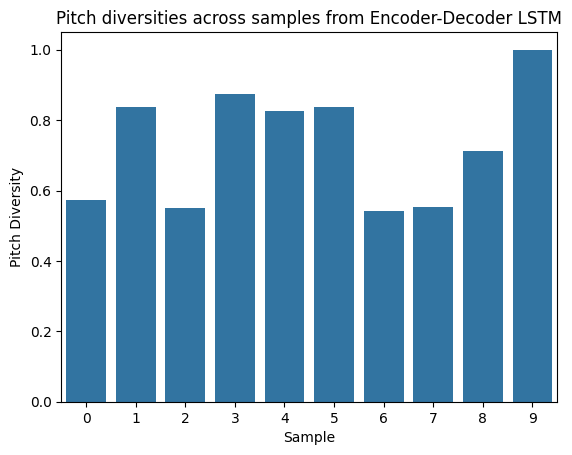

In [ ]:
encoder_decoder_generated_path = "../saved_data/samples/encoder_decoder_lstm/"
pitch_diversities_encoder_decoder = []
for i in range(10):
    pitches = extract_pitches_from_midi(os.path.join(encoder_decoder_generated_path, f"encoder_decoder_lstm_generated_song_{i+1}.mid"))
    pitch_diversities_encoder_decoder.append(calculate_pitch_diversity(pitches))

sns.barplot(pitch_diversities_encoder_decoder)
plt.title("Pitch diversities across samples from Encoder-Decoder LSTM")
plt.xlabel("Sample")
plt.ylabel("Pitch Diversity")
plt.show()

Here the pitches also seem very diverse.

It's time to now look at the performance of the GPT2 model:

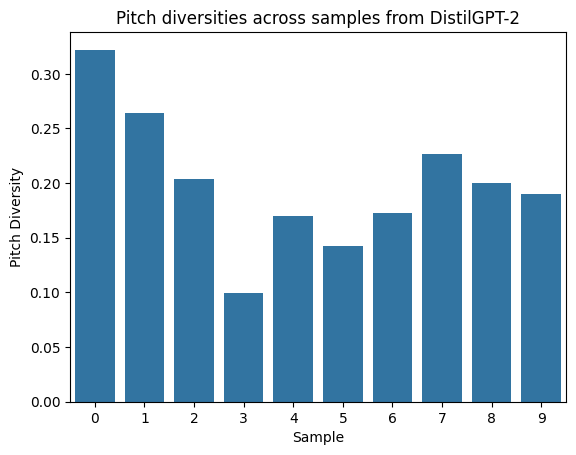

In [ ]:
gpt2_generated_path = "../saved_data/samples/gpt2/"
pitch_diversities_gpt2 = []
for i in range(10):
    pitches = extract_pitches_from_midi(os.path.join(gpt2_generated_path, f"gpt2_generated_song_{i+1}.mid"))
    pitch_diversities_gpt2.append(calculate_pitch_diversity(pitches))

sns.barplot(pitch_diversities_gpt2)
plt.title("Pitch diversities across samples from DistilGPT-2")
plt.xlabel("Sample")
plt.ylabel("Pitch Diversity")
plt.show()

Here, the overall pitch diversity is way lower.

Now we are going to take a look at the real data and see which one is the closest to it:

In [ ]:
metadata = pd.read_csv("../MAESTRO dataset/maestro-v3.0.0.csv")

In [ ]:
common_path = "../MAESTRO dataset/maestro-v3.0.0-midi/maestro-v3.0.0"
pitch_diversities_real = []
for filename in metadata[metadata["split"] == "test"]["midi_filename"]:
    pitches = extract_pitches_from_midi(os.path.join(common_path, filename))
    pitch_diversities_real.append(calculate_pitch_diversity(pitches))

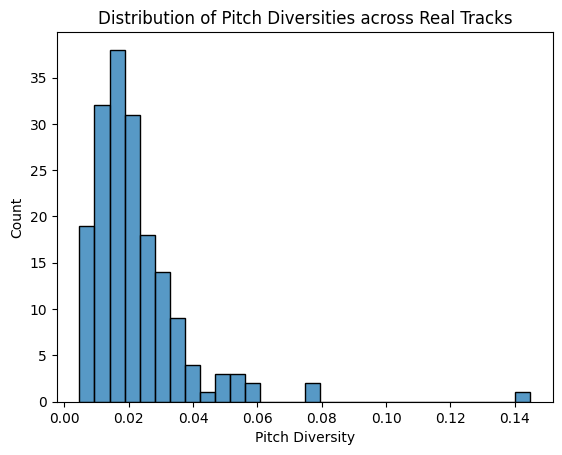

In [ ]:
sns.histplot(pitch_diversities_real)

plt.title("Distribution of Pitch Diversities across Real Tracks")
plt.xlabel("Pitch Diversity")

plt.show()

That's the complete opposite of what the models generate. Quite interesting...

For the sake of clarity, let's compare the mean pitch diversities for all 4 models:

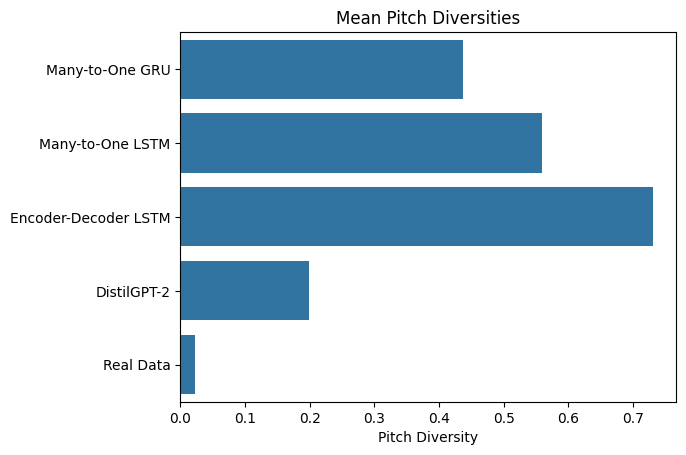

In [ ]:
pitch_diversities_dict = {}
pitch_diversities_dict["Many-to-One GRU"] = np.mean(pitch_diversities_gru)
pitch_diversities_dict["Many-to-One LSTM"] = np.mean(pitch_diversities_lstm)
pitch_diversities_dict["Encoder-Decoder LSTM"] = np.mean(pitch_diversities_encoder_decoder)
pitch_diversities_dict["DistilGPT-2"] = np.mean(pitch_diversities_gpt2)
pitch_diversities_dict["Real Data"] = np.mean(pitch_diversities_real)

sns.barplot(pitch_diversities_dict, orient="h")

plt.title("Mean Pitch Diversities")
plt.xlabel("Pitch Diversity")

plt.show()

Here it becomes apparent, that the GPT2 model is the closest in terms of pitch diversity. It's not very close to the real data, but it's closer to it than it's close to the other models.

#### **Rhythmic Consistency**
Here, we are going to extract the time intervals between each note and then calculate their entropy. This will give us the predictability of each rhythm. The lower the entropy, the more repetitive a track is. With higher entropy, the track becomes more diverse.

In [ ]:
def extract_rhythm(midi_file):
    midi = mido.MidiFile(midi_file)
    intervals = []
    last_time = 0
    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                if last_time > 0:
                    intervals.append(last_time)
                last_time += msg.time
            elif msg.type == 'note_off':
                intervals.append(last_time)
                last_time += msg.time
    return intervals

In [ ]:
def rhythmic_entropy(intervals):
    intervals = np.array(intervals)
    unique_intervals, counts = np.unique(intervals, return_counts=True)
    prob = counts / len(intervals)
    return entropy(prob)

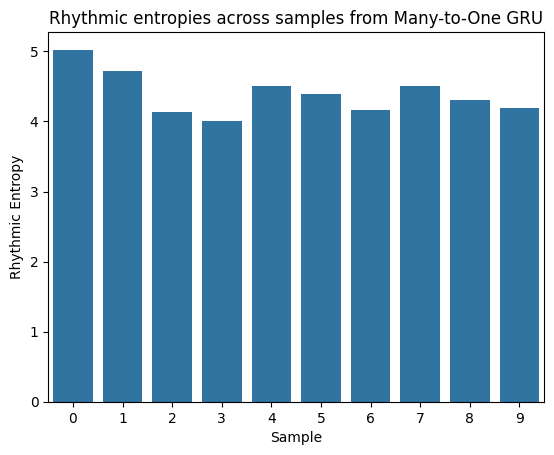

In [ ]:
rhythmic_entropies_gru = []
for i in range(10):
    intervals = extract_rhythm(os.path.join(many_to_one_gru_generated_path, f"many_to_one_gru_generated_song_{i+1}.mid"))
    rhythmic_entropies_gru.append(rhythmic_entropy(intervals))

sns.barplot(rhythmic_entropies_gru)
plt.title("Rhythmic entropies across samples from Many-to-One GRU")
plt.xlabel("Sample")
plt.ylabel("Rhythmic Entropy")
plt.show()

The GRU model is surprisingly consistent in its rhythms.

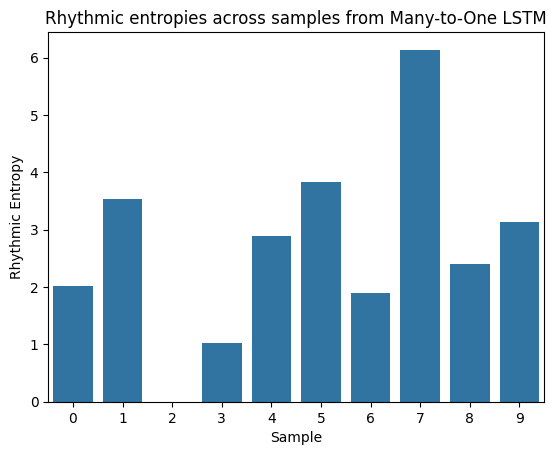

In [ ]:
rhythmic_entropies_lstm = []
for i in range(10):
    intervals = extract_rhythm(os.path.join(many_to_one_lstm_generated_path, f"many_to_one_lstm_generated_song_{i+1}.mid"))
    rhythmic_entropies_lstm.append(rhythmic_entropy(intervals))

sns.barplot(rhythmic_entropies_lstm)
plt.title("Rhythmic entropies across samples from Many-to-One LSTM")
plt.xlabel("Sample")
plt.ylabel("Rhythmic Entropy")
plt.show()

Here, the distribution is really diverse, which is strange.

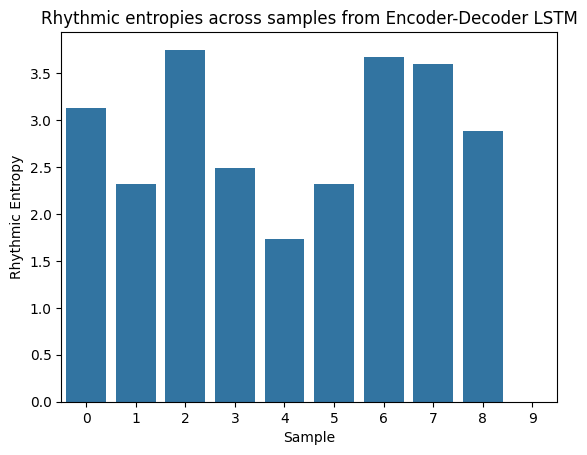

In [ ]:
rhythmic_entropies_encoder_decoder = []
for i in range(10):
    intervals = extract_rhythm(os.path.join(encoder_decoder_generated_path, f"encoder_decoder_lstm_generated_song_{i+1}.mid"))
    rhythmic_entropies_encoder_decoder.append(rhythmic_entropy(intervals))

sns.barplot(rhythmic_entropies_encoder_decoder)
plt.title("Rhythmic entropies across samples from Encoder-Decoder LSTM")
plt.xlabel("Sample")
plt.ylabel("Rhythmic Entropy")
plt.show()

The Encoder-Decoder model is more consistent in terms of its rhythmic entropy.

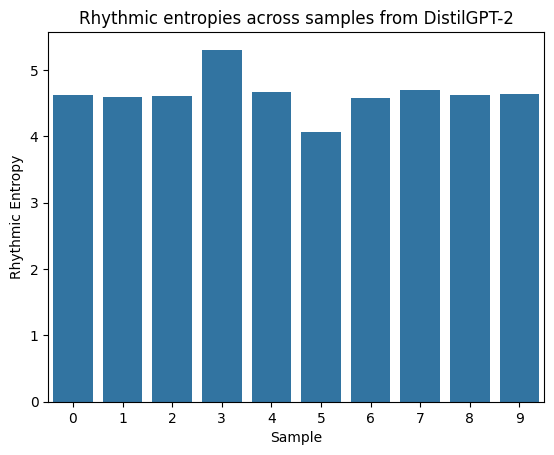

In [ ]:
rhythmic_entropies_gpt2 = []
for i in range(10):
    intervals = extract_rhythm(os.path.join(gpt2_generated_path, f"gpt2_generated_song_{i+1}.mid"))
    rhythmic_entropies_gpt2.append(rhythmic_entropy(intervals))

sns.barplot(rhythmic_entropies_gpt2)
plt.title("Rhythmic entropies across samples from DistilGPT-2")
plt.xlabel("Sample")
plt.ylabel("Rhythmic Entropy")
plt.show()

And the rhythmic entropy of the GPT2 model is the same almost everywhere.

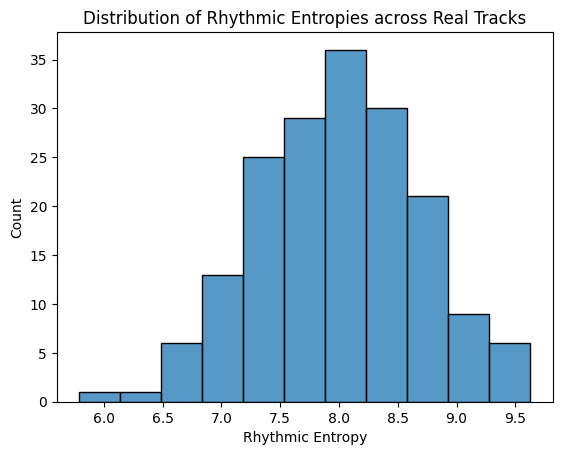

In [ ]:
rhythmic_entropies_real = []
for filename in metadata[metadata["split"] == "test"]["midi_filename"]:
    pitches = extract_rhythm(os.path.join(common_path, filename))
    rhythmic_entropies_real.append(rhythmic_entropy(pitches))

sns.histplot(rhythmic_entropies_real)

plt.title("Distribution of Rhythmic Entropies across Real Tracks")
plt.xlabel("Rhythmic Entropy")

plt.show()

The real songs have a higher rhythmic entropy than all of the generated ones, which I find strange. The music, produced by the models sounds very random and unstructured most of the times, yet this metric tells us the opposite.

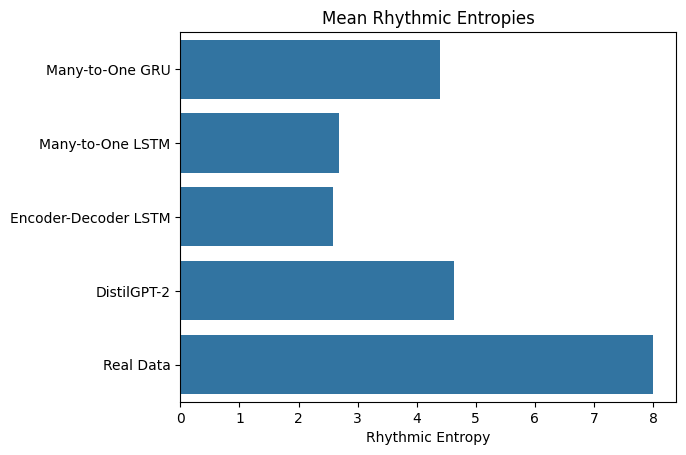

In [ ]:
rhythmic_entropies_dict = {}
rhythmic_entropies_dict["Many-to-One GRU"] = np.mean(rhythmic_entropies_gru)
rhythmic_entropies_dict["Many-to-One LSTM"] = np.mean(rhythmic_entropies_lstm)
rhythmic_entropies_dict["Encoder-Decoder LSTM"] = np.mean(rhythmic_entropies_encoder_decoder)
rhythmic_entropies_dict["DistilGPT-2"] = np.mean(rhythmic_entropies_gpt2)
rhythmic_entropies_dict["Real Data"] = np.mean(rhythmic_entropies_real)

sns.barplot(rhythmic_entropies_dict, orient="h")

plt.title("Mean Rhythmic Entropies")
plt.xlabel("Rhythmic Entropy")

plt.show()

Here it becomes even more apparent. Again, like last time, the closest to the real deal are the GPT2 and the Many-to-One GRU, although this time they are way closer to each other.

#### **Note Density**
The note density measures the average number of notes per second. That way we can get an insight if the generated music is sparse or dense. Typically, a density of < 1 means, that the music is very slow. A density between 1 and 5 means, that it's moderately dense and a density above 5 means, that the piece is very fast.

In [ ]:
def compute_note_density(midi_file_path):
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    total_notes = sum(len(inst.notes) for inst in midi_data.instruments)
    total_duration = midi_data.get_end_time()
    note_density = total_notes / total_duration if total_duration > 0 else 0
    return note_density

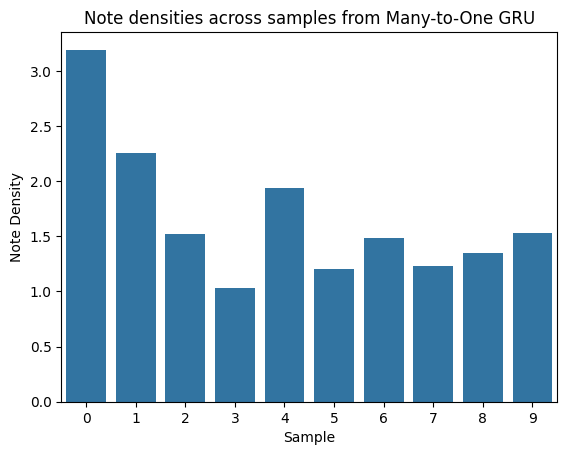

In [ ]:
note_densities_gru = []
for i in range(10):
    density = compute_note_density(os.path.join(many_to_one_gru_generated_path, f"many_to_one_gru_generated_song_{i+1}.mid"))
    note_densities_gru.append(density)

sns.barplot(note_densities_gru)
plt.title("Note densities across samples from Many-to-One GRU")
plt.xlabel("Sample")
plt.ylabel("Note Density")
plt.show()

The Many-to-One GRU again shows relatively consistent results across the samples with every single one of them being neither too dense, not too sparse. By listening, it becomes apparent, that this metric is very misleading, because most of the tracks contain several seconds of silence, then a burst of very fast notes.

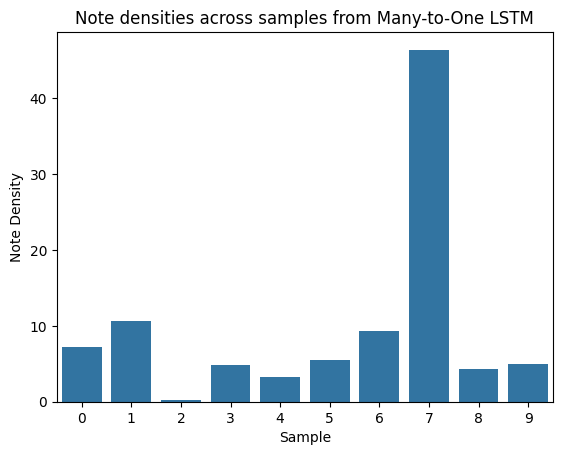

In [ ]:
note_densities_lstm = []
for i in range(10):
    density = compute_note_density(os.path.join(many_to_one_lstm_generated_path, f"many_to_one_lstm_generated_song_{i+1}.mid"))
    note_densities_lstm.append(density)

sns.barplot(note_densities_lstm)
plt.title("Note densities across samples from Many-to-One LSTM")
plt.xlabel("Sample")
plt.ylabel("Note Density")
plt.show()

The LSTM shows really diverse results, which is quite surprising.

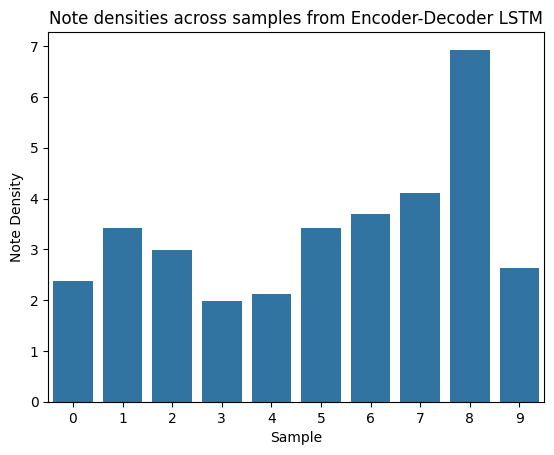

In [ ]:
note_densities_encoder_decoder = []
for i in range(10):
    density = compute_note_density(os.path.join(encoder_decoder_generated_path, f"encoder_decoder_lstm_generated_song_{i+1}.mid"))
    note_densities_encoder_decoder.append(density)

sns.barplot(note_densities_encoder_decoder)
plt.title("Note densities across samples from Encoder-Decoder LSTM")
plt.xlabel("Sample")
plt.ylabel("Note Density")
plt.show()

The Encoder-Decoder remains more consistent, although it's a bit on the quicker side.

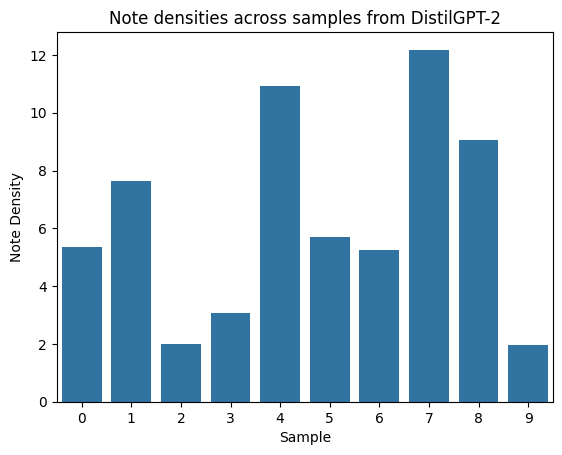

In [ ]:
note_densities_gpt2 = []
for i in range(10):
    density = compute_note_density(os.path.join(gpt2_generated_path, f"gpt2_generated_song_{i+1}.mid"))
    note_densities_gpt2.append(density)

sns.barplot(note_densities_gpt2)
plt.title("Note densities across samples from DistilGPT-2")
plt.xlabel("Sample")
plt.ylabel("Note Density")
plt.show()

The samples from GPT2 are really diverse and quick.

Now let's again look at the real data:

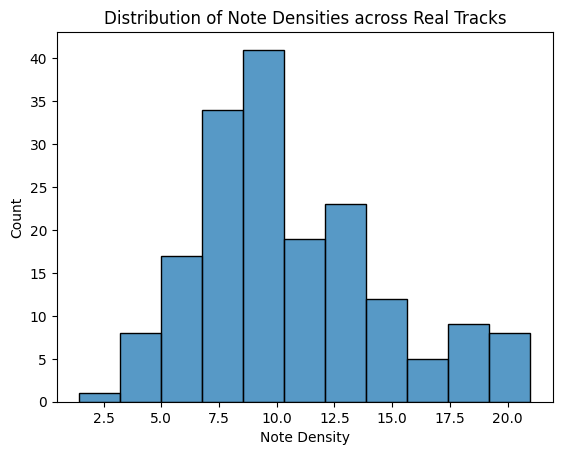

In [ ]:
note_densities_real = []
for filename in metadata[metadata["split"] == "test"]["midi_filename"]:
    density = compute_note_density(os.path.join(common_path, filename))
    note_densities_real.append(density)

sns.histplot(note_densities_real)

plt.title("Distribution of Note Densities across Real Tracks")
plt.xlabel("Note Density")

plt.show()

We can see, that the real songs are generally on the faster side. Let's again compare the average values:

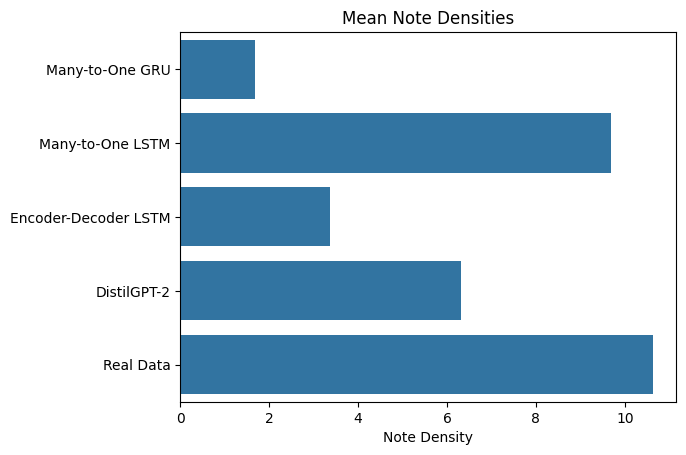

In [ ]:
note_densities_dict = {}
note_densities_dict["Many-to-One GRU"] = np.mean(note_densities_gru)
note_densities_dict["Many-to-One LSTM"] = np.mean(note_densities_lstm)
note_densities_dict["Encoder-Decoder LSTM"] = np.mean(note_densities_encoder_decoder)
note_densities_dict["DistilGPT-2"] = np.mean(note_densities_gpt2)
note_densities_dict["Real Data"] = np.mean(note_densities_real)

sns.barplot(note_densities_dict, orient="h")

plt.title("Mean Note Densities")
plt.xlabel("Note Density")

plt.show()

## **Subjective Measures**
Subjective measures measure the opinions of people after listening to samples from each model.

These are my opinions on the models (I'm not a music expert by any means).

#### **Many-to-One GRU**
After listening to the samples, it becomes apparent, that a model so shallow cannot get near to the level of structured and realistic music. Its output is fragmented with seconds of silence and bursts of random notes from time to time.

#### **Many-to-One LSTM**
The LSTM version of this architecture produces equally unrealistic tracks, but with fewer pauses. I think it's even a tiny bit worse than its GRU counterpart.

#### **Encoder-Decoder LSTM**
The Encoder-Decoder LSTM performs essentially the same as the other two. Again, this proves, that it's not deep enough. With random pauses and random bursts of many quick notes, no one can say, that this is music.

#### **DistilGPT-2**
The results of DistilGPT-2 are hit-or-miss, but still leagues above the other ones, as expected. Some of the tracks sound genuinely nice, while others seem kind of random, slow or both. Still, the larger model performs significantly better.